In [74]:
import torch
torch.manual_seed(123)
import random
random.seed(123)

import torch.nn as nn
import os
import shutil
import itertools

from IPython.display import clear_output
from chofer_torchex.utils.data.collate import dict_sample_target_iter_concat
from chofer_torchex.utils.functional import collection_cascade, cuda_cascade
from chofer_tda_datasets import Mpeg7
from jmlr_2018_code.utils import *
from chofer_torchex.nn.slayer import LinearRationalStretchedBirthLifeTimeCoordinateTransform, \
prepare_batch, SLayerRationalHat
from sklearn.model_selection import ShuffleSplit
from collections import Counter, defaultdict
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.autograd import Variable
from matplotlib.ticker import FormatStrFormatter

from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib notebook
%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES'] = str(0)


class train_env:
    nu = 0.01
    n_epochs = 200
    lr_initial = 0.01
    momentum = 0.9
    lr_epoch_step = 40
    batch_size = 100
    train_size = 0.9
    train_test_splits = None
    

coordinate_transform = LinearRationalStretchedBirthLifeTimeCoordinateTransform(nu=train_env.nu)
            

used_directions = ['dim_0_dir_{}'.format(i) for i in range(0, 32,2)]
dataset = Mpeg7(root_dir='/scratch1/chofer/jmlr2018_data/')
dataset.data_transforms = [
                           lambda x: {k: x[k] for k in used_directions}, 
                           numpy_to_torch_cascade,
                           lambda x: collection_cascade(x, 
                                                        lambda x: isinstance(x, torch._TensorBase), 
                                                        lambda x: coordinate_transform(x))
                           ]


splitter = StratifiedShuffleSplit(n_splits=10, 
                                  train_size=train_env.train_size, 
                                  test_size=1-train_env.train_size, 
                                  random_state=123)
train_test_splits = list(splitter.split(X=dataset.labels, y=dataset.labels))
train_test_splits = [(train_i.tolist(), test_i.tolist()) for train_i, test_i in train_test_splits]
train_env.train_test_splits = train_test_splits

output_path = './results/mpeg7__slayer_parameter_learning_impact.pickle'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found data!


In [2]:
class PHTCollate:   
    def __init__(self, nu, cuda=True, rotation_augmentation=False):
        self.cuda = cuda
        self.rotation_augmentation = rotation_augmentation
        
    def __call__(self, sample_target_iter):
        
        augmented_samples = []
        if self.rotation_augmentation:
            samples, targets = [], []
            for x, y in sample_target_iter:                
                i = random.randint(0, len(used_directions)-1)
                shifted_keys = used_directions[i:] + used_directions[:i]                
                
                samples.append({k: x[ki] for k, ki in zip(used_directions, shifted_keys)})
                targets.append(y)
                
            sample_target_iter = zip(samples, targets)

        x, y = dict_sample_target_iter_concat(sample_target_iter)                                            
                                              
        for k in x.keys():
            batch_view = x[k]
            x[k] = prepare_batch(batch_view, 2)                  

        y = torch.LongTensor(y)    

        if self.cuda:
            # Shifting the necessary parts of the prepared batch to the cuda
            x = {k: collection_cascade(v,
                                       lambda x: isinstance(x, tuple),
                                       lambda x: (x[0].cuda(), x[1].cuda(), x[2], x[3]))
                 for k, v in x.items()}

            y = y.cuda()

        return x, y                       
    
collate_fn = PHTCollate(train_env.nu, cuda=True)

In [3]:
def Slayer(n_elements):
    return SLayerRationalHat(n_elements, radius_init=0.25, exponent=1)

def LinearCell(n_in, n_out):
    m = nn.Sequential(nn.Linear(n_in, n_out), 
                      nn.BatchNorm1d(n_out), 
                      nn.ReLU(),
                     )
    m.out_features = m[0].out_features
    return m


class MpegModel(nn.Module):
    def __init__(self, n_elements: int, train_slayers: bool):
        super().__init__()   
        self.n_elements = n_elements
        self.train_slayers = bool(train_slayers)
        
        self.slayers = ModuleDict()
        for k in used_directions:
            s = Slayer(self.n_elements)
            self.slayers[k] = nn.Sequential(s)            
            
        cls_in_dim = len(used_directions)*self.n_elements
        self.cls = nn.Sequential(
                                nn.Dropout(0.3),
                                LinearCell(cls_in_dim, int(cls_in_dim/4)),    
                                nn.Dropout(0.2),
                                LinearCell(int(cls_in_dim/4), int(cls_in_dim/16)),  
                                nn.Dropout(0.1),
                                nn.Linear(self.n_elements, 70))
        
    def forward(self, input):
        x = []
        for k in used_directions:            
            xx = self.slayers[k](input[k])
            x.append(xx)

        x = torch.cat(x, dim=1)          
        x = self.cls(x)       
                                              
        return x
    
    def k_means_center_init(self, sample_target_iter):
        centers = k_means_center_init(sample_target_iter, self.n_elements)
        
        for k, v in centers.items():
            self.slayers._modules[k][0].centers.data = v
            
    def min_max_random_init(self, sample_target_iter):
        centers = min_max_random_init(sample_target_iter, self.n_elements)
        
        for k, v in centers.items():
            self.slayers._modules[k][0].centers.data = v
            
    def parameters(self):
        p = []
        p.append(self.cls.parameters())
        
        if self.train_slayers:
            for slayer in self.slayers._modules.values():
                p.append(slayer.parameters())
                
        
        ret = itertools.chain(*p)
        
        return ret            

In [5]:
def experiment(n_elements: int, train_slayers: bool, centers_init: str):    
    stats_of_runs = []   
    
    for run_i, (train_i, test_i) in enumerate(train_env.train_test_splits):
#         print('')
#         print('Run', run_i)     

        model = MpegModel(n_elements=n_elements, train_slayers=train_slayers)
        
        if centers_init == 'k_means':
            model.k_means_center_init([dataset[i] for i in train_i])
        elif centers_init == 'min_max_random':
            model.min_max_random_init([dataset[i] for i in train_i])
            
            
        model.cuda()

        stats = defaultdict(list)
        stats_of_runs.append(stats)
        
        opt = torch.optim.SGD(model.parameters(), lr=train_env.lr_initial, momentum=train_env.momentum)

        for i_epoch in range(1, train_env.n_epochs+1):      

            model.train()
            
            train_sampler = [i for i in train_i]
            random.shuffle(train_sampler)
            dl_train = DataLoader(dataset,
                              batch_size=train_env.batch_size, 
                              collate_fn=collate_fn,
                              sampler=train_sampler)

            dl_test = DataLoader(dataset,
                                 batch_size=train_env.batch_size, 
                                 collate_fn=collate_fn, 
                                 sampler=test_i)

            epoch_loss = 0    

            if i_epoch % train_env.lr_epoch_step == 0:
                adapt_lr(opt, lambda lr: lr*0.5)

            for i_batch, (x, y) in enumerate(dl_train, 1):              

                y = torch.autograd.Variable(y)

                def closure():
                    opt.zero_grad()
                    y_hat = model(x)            
                    loss = nn.functional.cross_entropy(y_hat, y)   
                    loss.backward()
                    return loss

                loss = opt.step(closure)

                epoch_loss += float(loss)
                stats['loss_by_batch'].append(float(loss))
                stats['centers'].append(model.slayers['dim_0_dir_0'][0].centers.data.cpu().numpy())

                print("Run, {}/{}, Epoch {}/{}, Batch {}/{}".format(run_i, 10, i_epoch, train_env.n_epochs, i_batch, len(dl_train)), end="       \r")
                
            stats['train_loss_by_epoch'].append(epoch_loss/len(dl_train))            
                     
            model.eval()    
            true_samples = 0
            seen_samples = 0
            epoch_test_loss = 0
            for i_batch, (x, y) in enumerate(dl_test):

                y_hat = model(x)
                epoch_test_loss += float(nn.functional.cross_entropy(y_hat, torch.autograd.Variable(y.cuda())).data)

                y_hat = y_hat.max(dim=1)[1].data.long()

                true_samples += (y_hat == y).sum()
                seen_samples += y.size(0)  

            stats['test_accuracy'].append(true_samples/seen_samples)
            stats['test_loss_by_epoch'].append(epoch_test_loss/len(dl_test))
#             print('')
#             print(true_samples/seen_samples)
            
#         print('')
#         print('acc.', np.mean(stats['test_accuracy'][-10:]))
        print('\r' + ' '*100, end='\r')
    
#     path = './results/mpeg7__n_elements_{}__train_slayers={}__centers_init={}.pickle'.format(train_slayers, centers_init)
#     with open(path, 'bw') as f:
#         pickle.dump(stats_of_runs, f)
        
    return stats_of_runs

In [7]:
n = [25, 50, 75, 100, 125, 150]
overall_result = None
if os.path.isfile(output_path):
    with open(output_path, 'br') as f:
        overall_result = pickle.load(f)
else:
    overall_result = OrderedDict()

for n_elements, train_slayers, centers_init in itertools.product(n, [True, False], ['k_means', 'min_max_random']):
    print(n_elements, train_slayers, centers_init)
    
    stats_of_runs = None
    
    if (n_elements, train_slayers, centers_init) not in overall_result:   
        
        stats_of_runs = experiment(n_elements=n_elements, 
                                   train_slayers=train_slayers, 
                                   centers_init=centers_init)
        
        overall_result[(n_elements, train_slayers, centers_init)] = stats_of_runs
    
        with open(output_path , 'bw') as f:
            pickle.dump(overall_result, f)
            
    else:
        
        stats_of_runs = overall_result[(n_elements, train_slayers, centers_init)]
    accs = [np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]
    print('->', np.mean(accs), '+-', np.std(accs))
    
    
    
    

25 True k_means
-> 0.8867857142857142 +- 0.02264691266069667
25 True min_max_random
-> 0.8417857142857142 +- 0.025527596112154882
25 False k_means
-> 0.8732142857142857 +- 0.026330416182174736
25 False min_max_random
-> 0.7697142857142857 +- 0.03552406485290593
50 True k_means
-> 0.9142142857142858 +- 0.016880280730811933                                                       
50 True min_max_random
-> 0.8959999999999999 +- 0.02296448011470705                                                        
50 False k_means
-> 0.9083571428571429 +- 0.024623802156715356                                                       
50 False min_max_random
-> 0.8564999999999999 +- 0.03300193253463209                                                        
75 True k_means
-> 0.9177142857142858 +- 0.020861056384310586                                                       
75 True min_max_random
-> 0.9056428571428571 +- 0.01410764013590084                                                        
75 False k_me

/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


-> 0.9188571428571428 +- 0.017035976338206086                                                       
100 True min_max_random
-> 0.9057857142857143 +- 0.02213237078883988                                                        
100 False k_means
-> 0.9139285714285714 +- 0.01910029917491943                                                        
100 False min_max_random
-> 0.8920714285714286 +- 0.01852865954379306                                                        
125 True k_means
-> 0.9218571428571428 +- 0.014757218918349151                                                       
125 True min_max_random
-> 0.9206428571428571 +- 0.018569917520944813                                                       
125 False k_means
-> 0.9166428571428572 +- 0.015962487914111714                                                       
125 False min_max_random
-> 0.901142857142857 +- 0.01630762936512241                                                         
150 True k_means
-> 0.9214285714285715 +-

In [4]:
with open(output_path, 'br') as f:
    overall_result = pickle.load(f)

<IPython.core.display.Javascript object>


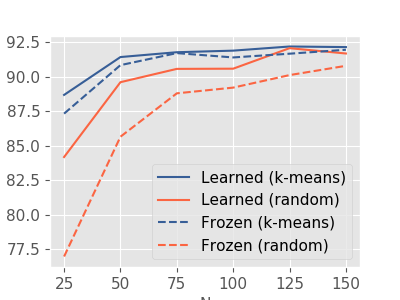

In [61]:
def get_label_from_key(key):
    learned, init = key
    
    ret = ''
    if learned:
        ret += 'Learned'
    else:
        ret += 'Frozen'
        
    ret += ' ('
    
    if init == 'k_means':
        ret += 'k-means'
    else:
        ret += 'random'
        
    ret += ')'
        
    return ret

n = [25, 50, 75, 100, 125, 150]

accuracies = defaultdict(list)
stddevs = defaultdict(list)

for parametrization, stats_of_runs in overall_result.items():
    n_elements, trained, init = parametrization
    
    accuracies_of_runs = [np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]
    
    accuracies[(trained, init)].append((n_elements, np.mean(accuracies_of_runs)))
    stddevs[(trained, init)].append((n_elements, np.std(accuracies_of_runs)))
    
def clean(d):
    ret = {}
    for k, v in d.items():
        ret[k] = [val for _, val in sorted(v, key=lambda x: x[0])]
        
    return ret

accuracies = clean(accuracies)
stddevs = clean(stddevs)

plt.figure(figsize=(4, 3))

plt.style.use('ggplot')


fs = 11
plt.xlabel('N', fontsize=fs)
plt.ylabel('Avg. accuracy [%]', fontsize=fs)

plt.gca().tick_params(labelsize=fs)

colors = ['#375E97', '#FB6542']
for k, acc_i in accuracies.items():
    std_i = stddevs[k]
    acc_i = [x*100 for x in acc_i]
    
    line_style = '-' if k[0] else '--'   
    c = colors[0] if k[1] == 'k_means' else colors[1]
    
    plt.plot(n, acc_i, label=get_label_from_key(k), c=c, linestyle=line_style)
    upper_bound = [x+100*y for x,y in zip(acc_i, std_i)]
    lower_bound = [x-100*y for x,y in zip(acc_i, std_i)]
    
#     plt.plot(n, upper_bound, '--', c=c, alpha=0.3)
#     plt.plot(n, lower_bound, '--', c=c, alpha=0.3)
    
#     plt.fill_between(n, lower_bound, upper_bound, facecolor=c, alpha=0.3)
    
    
plt.legend(fontsize=fs)

plt.savefig('/tmp/mpeg7_impact_of_slayer_trainig.pdf', bbox_inches='tight', pad_inches=0)

<IPython.core.display.Javascript object>


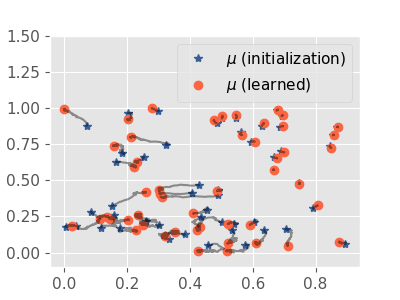

<IPython.core.display.Javascript object>


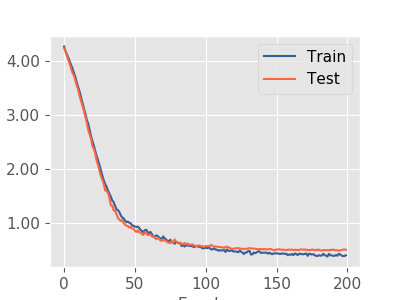

In [82]:
stats = overall_result[(50, True, 'min_max_random')][0]


if 'centers' in stats:
    
    plt.figure(figsize=(4, 3))
    plt.gca().tick_params(labelsize=fs)
    
    c_start = stats['centers'][0]
    c_end = stats['centers'][-1]

    plt.plot(c_start[:,0], c_start[:, 1], '*', label='$\mu$ (initialization)', c=colors[0])
    plt.plot(c_end[:,0], c_end[:, 1], 'o', label='$\mu$ (learned)', c=colors[1])
    plt.ylim(-0.1, 1.5)
    
    plt.xlabel(' ', fontsize=fs)
    plt.ylabel(' ', fontsize=fs)

    all_centers = numpy.stack(stats['centers'], axis=0)
    for i in range(all_centers.shape[1]):
        points = all_centers[:,i, :]
        plt.plot(points[:, 0], points[:, 1], '-k', alpha=0.40)
        

    plt.legend(loc=1, fontsize=fs)
    
plt.savefig('/tmp/centers_learning_progress.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
    
plt.figure(figsize=(4, 3))
plt.gca().tick_params(labelsize=fs)

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xlabel('Epochs', fontsize=fs)
plt.ylabel('Loss', fontsize=fs)
plt.plot(stats['train_loss_by_epoch'], label='Train', c=colors[0])
plt.plot(stats['test_loss_by_epoch'], label='Test', c=colors[1])
# plt.plot(stats['test_accuracy'], label='test_accuracy')

plt.legend(fontsize=fs)    
plt.savefig('/tmp/loss_learning_progress.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
result = experiment(n_elments=25, 
                    train_slayers=True, 
                    centers_init='min_max_random')
clear_output()
accuracies = [np.mean(s['test_accuracy'][-10:]) for s in result]
print(accuracies, '->', np.mean(accuracies), '+/-', np.std(accuracies))

In [ ]:
result = experiment(n_elments=25, 
                    train_slayers=False, 
                    centers_init='min_max_random')
clear_output()
accuracies = [np.mean(s['test_accuracy'][-10:]) for s in result]
print(accuracies, '->', np.mean(accuracies), '+/-', np.std(accuracies))

In [ ]:
result = experiment(n_elments=25, 
                    train_slayers=True, 
                    centers_init='k_means')
clear_output()
accuracies = [np.mean(s['test_accuracy'][-10:]) for s in result]
print(accuracies, '->', np.mean(accuracies), '+/-', np.std(accuracies))

In [ ]:
result = experiment(n_elments=25, 
                    train_slayers=False, 
                    centers_init='k_means')
clear_output()
accuracies = [np.mean(s['test_accuracy'][-10:]) for s in result]
print(accuracies, '->', np.mean(accuracies), '+/-', np.std(accuracies))

In [ ]:
print(np.mean([np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]))
[np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]